### Clase 3

#### Sección 3

In [1]:
import csv
import os
import numpy as np
import pandas as pd
from numpy.typing import ArrayLike
from IPython.display import display, Markdown
import matplotlib.pyplot as plt

Cargamos el conjunto de datos como una listas de listas.

In [2]:
path = os.path.join('..','Datasets','GLT_filtrado.csv')

conjunto = [[],[],[],[],[],[],[]]

with open(path, 'r') as f:
    data = list(csv.reader(f))

    labels = data[0]

    for i in data[1:]:
        conjunto[0].append(i[0] if i[0]!='' else np.nan)
        conjunto[1].append(float(i[1]) if i[1]!='' else np.nan)
        conjunto[2].append(float(i[2]) if i[2]!='' else np.nan)
        conjunto[3].append(i[3] if i[3]!='' else np.nan)
        conjunto[4].append(i[4] if i[4]!='' else np.nan)
        conjunto[5].append(i[5] if i[5]!='' else np.nan)
        conjunto[6].append(i[6] if i[6]!='' else np.nan)

Contestemos las siguientes preguntas:

* ¿Tipo de dato de los atributos? <--- FALTA!!
* ¿Cuántas entradas hay?
* ¿Cuántas ciudades distintas?

In [3]:
# Total de datos
total = len(data[1:])
print(f'Total de datos: {total}')

# El índice 3 de `conjunto`` corresponde a las ciudades
ciudades_unicas = np.unique(conjunto[3])
print(f"Tenemos {len(ciudades_unicas)} ciudades únicas.")



Total de datos: 219575
Tenemos 100 ciudades únicas.


¿Cuantos valores faltantes hay en el atributo AverageTemperature?

In [4]:
# El índice 1 de `conjunto` corresponde a AverageTemperature
faltan = np.count_nonzero(np.isnan(conjunto[1]))
print(f"Hay {faltan} valores faltantes en el atributo 'AverageTemperature'.")
print(f"Los datos faltantes representan el {faltan*100/total:.2f}%")
print('-'*80)

# Verificamos valores faltantes para los demás atributos
for i in range(7):
    if i==1:
        continue
    print(f"Hay {np.count_nonzero(pd.isna(conjunto[i]))} valores faltantes en el atributo '{labels[i]}'")   # pd.isna() para que no haya error en la iteración

Hay 27581 valores faltantes en el atributo 'AverageTemperature'.
Los datos faltantes representan el 12.56%
--------------------------------------------------------------------------------
Hay 0 valores faltantes en el atributo 'Date'
Hay 27581 valores faltantes en el atributo 'AverageTemperatureUncertainty'
Hay 0 valores faltantes en el atributo 'City'
Hay 0 valores faltantes en el atributo 'Country'
Hay 0 valores faltantes en el atributo 'Latitude'
Hay 0 valores faltantes en el atributo 'Longitude'


Como vemos, los valores faltantes para AverageTemperature (así como para AverageTemperatureUncertainty) representan el 12.56%

En primera instancia no sabemos la ubicación de los valores faltantes en el conjunto de datos, es decir, hasta este punto no sabemos a qué fechas y/o ciudades les están faltando valores. El porcentaje que representan los valores faltantes es significativo pues afecta la distribución de la temperatura generando una importante dispersión en los datos. Se espera que esta distribución sea continua y suave en el tiempo pues esta es la naturaleza física del cambio en temperatura, es decir, sin saltos abruptos. Por ello, necesitamos aplicar una estrategia que nos permita rellenar de forma coherente los huecos faltantes para reducir el sesgo y dispersión, la cual se verá a continuación.

In [5]:
def llenar_faltantes(ar: ArrayLike) -> list[float]:
    """
    La función toma un arreglo y llena cualquier vacío (NaN) con la media aritmética entre la medición antecedente más cercana y la medición sucesiva más cercana.
    La función recorre el arreglo de izquierda a derecha. 
    En caso de que un valor NaN esté al inicio (final) del arreglo, se considera que a dicho valor le antecede (sigue) el valor 0 y se calcula la media con dicho valor.

    :param ar: Arreglo de una dimensión

    :return: Lista
    """
    ar_copy = list(ar)
    
    for i,_ in enumerate(ar_copy):
        if np.isnan(ar_copy[i]):
            if i == 0:
                anterior = 0
            else: 
                anterior = ar_copy[i-1]

            j = i
            while np.isnan(ar_copy[j]):
                if j == len(ar_copy)-1:
                    siguiente = 0
                    break
                else:
                    siguiente = ar_copy[j+1]
                    j+=1

            prom = (anterior + siguiente) / 2
            ar_copy[i] = prom
    
    return ar_copy

Probamos la función:

- Primer ejemplo:

    - La lista inicial es:
    ```python
        [ np.nan, 5, 6, np.nan ]
    ```
    - La lista final debe ser:
    ```python
        [ 2.5, 5, 6, 3 ]
    ```
- Segundo ejemplo:

    - La lista inicial es:
    ```python
        [ np.nan, np.nan, 24, 28.9 ]
    ```
    - La lista final debe ser: 
    ```python
        [ 12.0, 18.0, 24, 28.9 ]
    ```

> Nota: La función itera sobre cada elemento del arreglo para buscar valores NaN. Esto es un proceso tardado cuando se trata de arreglos grandes. Como solución se pueden obtener solamente los índices en donde hay valores NaN e iterar sobre estos. Esto se puede realizar con ``` np.where(np.isnan(Array))[0] ```

In [6]:
q_1 = [ np.nan, 5, 6, np.nan ]
q_2 = [ np.nan, np.nan, 24, 28.9 ]

Q_1 = llenar_faltantes(q_1)
Q_2 = llenar_faltantes(q_2)

print(f"""
      Lista original --> lista final
    {q_1} --> {Q_1}
{q_2} --> {Q_2}
""")


      Lista original --> lista final
    [nan, 5, 6, nan] --> [2.5, 5, 6, 3.0]
[nan, nan, 24, 28.9] --> [12.0, 18.0, 24, 28.9]



Aplicamosa ahora la función `llenar_faltantes` al conjunto de datos `conjunto[1]` que corresponde a `AverageTemperature`

In [7]:
AverageTemperature_full = llenar_faltantes(conjunto[1])

In [8]:
q = [np.nan, np.nan,np.nan,24, np.nan,np.nan,np.nan]
q = [np.nan, np.nan, np.nan,np.nan,100, np.nan, np.nan,np.nan]

d = q
flag = False
i = 0
k = 0

while True:
    if np.isnan(q[i]):
        if i==0:
            anterior = 0
        else: 
            anterior = q[i-1]

        j = i
        while np.isnan(q[j]):
            if j == len(q)-1:
                siguiente = 0
                flag = True
                q.reverse()
                k=i
                i=0
                break
            else:
                siguiente = q[j+1]
                j+=1

        prom = (anterior + siguiente) / 2
        d[i] = prom

    if i == len(q) - 1 and flag == False:
        break
    if i == len(q) - k - 1 and flag == True:  # i==7-4-1 = 2
        q.reverse()
        break

    i+=1
        
# d

#### Sección 4

##### 4.1

Encuentra la temperatura más caliente y más fría en estas ciudades: Cairo, Moscow, Peking, Rome, Mexico.

In [9]:
# El índice 3 de `conjunto` corresponde a City

''' Cairo '''
cairo_idx = np.where(np.array(conjunto[3])=='Cairo')[0]
cairo_temp = np.array(AverageTemperature_full)[cairo_idx]

''' Moscow '''
moscow_idx = np.where(np.array(conjunto[3])=='Moscow')[0]
moscow_temp = np.array(AverageTemperature_full)[moscow_idx]

''' Peking '''
peking_idx = np.where(np.array(conjunto[3])=='Peking')[0]
peking_temp = np.array(AverageTemperature_full)[peking_idx]

''' Rome '''
rome_idx = np.where(np.array(conjunto[3])=='Rome')[0]
rome_temp = np.array(AverageTemperature_full)[rome_idx]

''' México '''
mexico_idx = np.where(np.array(conjunto[3])=='Mexico')[0]
mexico_temp = np.array(AverageTemperature_full)[mexico_idx]

In [10]:
markdown_text = f"""

| Ciudad       | Temperatura Mínima     | Temperatura Máxima     |
|--------------|------------------------|------------------------|
| Cairo        | {np.min(cairo_temp)}   | {np.max(cairo_temp)}   |
| Moscow       | {np.min(moscow_temp)}  | {np.max(moscow_temp)}  |
| Peking       | {np.min(peking_temp)}  | {np.max(peking_temp)}  |
| Rome         | {np.min(rome_temp)}    | {np.max(rome_temp)}    |
| México       | {np.min(mexico_temp)}  | {np.max(mexico_temp)}  |

"""

display(Markdown(markdown_text))



| Ciudad       | Temperatura Mínima     | Temperatura Máxima     |
|--------------|------------------------|------------------------|
| Cairo        | 10.326   | 30.767   |
| Moscow       | -19.376  | 24.58  |
| Peking       | -8.579  | 28.936  |
| Rome         | -1.4410000000000005    | 25.951    |
| México       | 9.127  | 21.0  |



##### 4.2

Hay una anomalía en la distribución de datos. Con la ayuda de Matplotlib, grafica la distribución de las temperaturas medias terrestres para Roma y Bangkok.

> El número de bins se calcula  automáticamente con la opción `bins = 'auto'` <br>
> Referencia: https://numpy.org/doc/stable/reference/generated/numpy.histogram_bin_edges.html

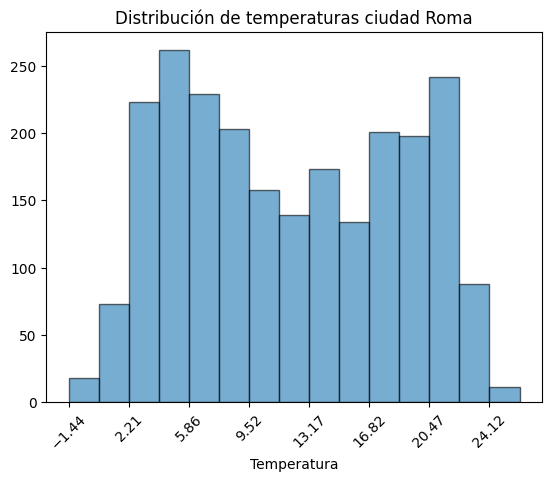

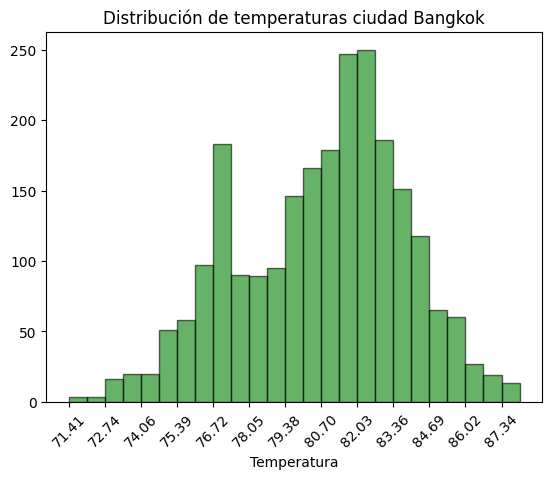

In [11]:
''' Bangkok '''
bangkok_idx = np.where(np.array(conjunto[3])=='Bangkok')[0]
bangkok_temp = np.array(AverageTemperature_full)[bangkok_idx]


# ''' General '''
# plt.figure(figsize=(5,5))
# plt.hist(np.array(AverageTemperature_full)[np.where(np.array(conjunto[3])=='Rome')[0]], bins='auto')
# plt.xticks(rotation=90)
# plt.show()

color = ('Black', 0.6)
bins_rome = np.histogram_bin_edges(rome_temp, bins='auto')
plt.hist(rome_temp, bins=bins_rome, edgecolor=color[0], alpha=color[1])
plt.title('Distribución de temperaturas ciudad Roma')
plt.xlabel('Temperatura')
plt.xticks(bins_rome[::2], rotation=45)
plt.show()

bins_bangkok = np.histogram_bin_edges(bangkok_temp, bins='auto')
plt.hist(bangkok_temp, bins=bins_bangkok, color='green', edgecolor=color[0], alpha=color[1])
plt.title('Distribución de temperaturas ciudad Bangkok')
plt.xlabel('Temperatura')
plt.xticks(bins_bangkok[::2], rotation=45)
plt.show()


# fig, ax = plt.subplots(2,1,figsize=(10,6))
# color = ('Black', 0.6)
# ax[0].hist(rome_temp, bins='auto', edgecolor=color[0], alpha=color[1])
# ax[0].set_title('Distribución de temperaturas ciudad Roma')
# ax[0].set_xlabel('Temperatura')
# ax[1].hist(bangkok_temp, bins='auto', color='green', edgecolor=color[0], alpha=color[1])
# ax[1].set_title('Distribución de temperaturas ciudad Bangkok')
# ax[1].set_xlabel('Temperatura')

# plt.tight_layout(h_pad=5)
# plt.show()

##### 4.3

Como puedes ver, Roma y Bangkok tienen distribuciones de temperatura muy diferentes. Sin embargo, lo que resulta extraño es la gran diferencia en la magnitud de sus temperaturas. Es posible que todos los sensores de las
estaciones de Bangkok estuvieran defectuosos? Qué crees que pudo haber sucedido aquí? Hay otras ciudades que presentan el mismo problema? Usa tu creatividad para analizarlo y proponer una explicación.

El registro de temperaturas está en °F.
Tener temperaturas por encima de 70 °C es demasiado.

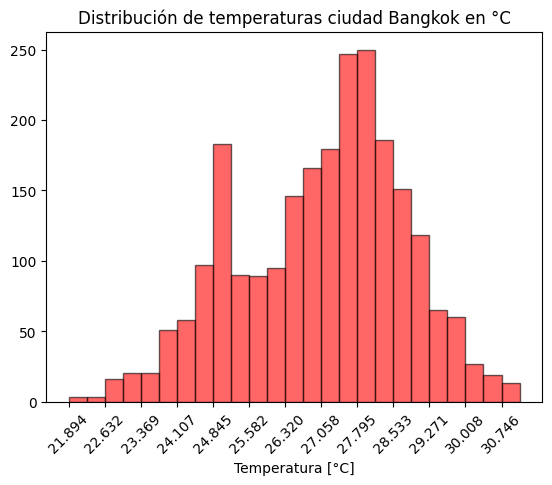

In [12]:
bangkok_temp_C = (5/9)*(bangkok_temp - 32)

bins_bangkok_C = np.histogram_bin_edges(bangkok_temp_C, bins='auto')
plt.hist(bangkok_temp_C, bins=bins_bangkok_C, color='red', edgecolor=color[0], alpha=color[1])
plt.title('Distribución de temperaturas ciudad Bangkok en °C')
plt.xlabel('Temperatura [°C]')
plt.xticks(bins_bangkok_C[::2], rotation=45)
plt.show()


Para revisar si hay otras ciudades presentando el mismo problema basta con encontrar el máximo del conjunto de temperaturas en el que no se considere a Bangkok. Si dentro del conjunto la temperatura más alta es razonable en unidades °C entonces no habrá otra ciudad dentro del conjunto de datos que esté en °F.

In [13]:
# Índices donde no está Bangkok
idx = np.where(np.array(conjunto[3]) != 'Bangkok')[0]

# Conjunto de temperaturas donde no están las de Bangkok
temp = np.array(AverageTemperature_full)[idx]

np.max(temp) # Solo Bangkok está con otras unidades: °F
np.min(temp) # La ciudad más fría tiene un rango de temperaturas coherente.

np.float64(-26.772)

##### 4.4

Ahora sí, ya que lo encontraste, calcula la temperatura media anual para las siguientes ciudades: London, New York, Bangkok, Tokyo, Paris, Lima. Puedes agregar las ciudades que desees y que te interesen.

In [53]:
i = np.where(np.array(conjunto[3]) == 'London')[0]

d = np.array(conjunto[0])[i]

t = np.array(AverageTemperature_full)[i]

years = np.array([date[:4] for date in d])

unique_years = np.unique(years)

indices_by_year = {year: np.where(years == year)[0] for year in unique_years}

# for year, indices in indices_by_year.items():
#     print(f"Año {year}: Índices {indices}")

{year: np.mean(t[indices])  for year, indices in indices_by_year.items()}



{np.str_('1817'): np.float64(8.948416666666668),
 np.str_('1818'): np.float64(9.845749999999999),
 np.str_('1819'): np.float64(9.625916666666667),
 np.str_('1820'): np.float64(8.50325),
 np.str_('1821'): np.float64(9.628208333333335),
 np.str_('1822'): np.float64(10.360416666666667),
 np.str_('1823'): np.float64(8.455458333333333),
 np.str_('1824'): np.float64(9.602),
 np.str_('1825'): np.float64(9.999291666666666),
 np.str_('1826'): np.float64(10.162625),
 np.str_('1827'): np.float64(9.176208333333333),
 np.str_('1828'): np.float64(10.221916666666667),
 np.str_('1829'): np.float64(7.947833333333334),
 np.str_('1830'): np.float64(8.784833333333333),
 np.str_('1831'): np.float64(9.896541666666666),
 np.str_('1832'): np.float64(9.139125000000002),
 np.str_('1833'): np.float64(9.396),
 np.str_('1834'): np.float64(10.593291666666667),
 np.str_('1835'): np.float64(9.823229166666666),
 np.str_('1836'): np.float64(9.020791666666668),
 np.str_('1837'): np.float64(8.853333333333333),
 np.str_('

In [50]:
def Annual_Mean_Temperature(city: str):
    """

    """
    indices_ciudad = np.where(np.array(conjunto[3]) == city)[0]

    fechas = np.array(conjunto[0])[indices_ciudad]

    temperaturas = np.array(AverageTemperature_full)[indices_ciudad]

    years = np.array([date[:4] for date in fechas])

    unique_years = np.unique(years)

    indices_by_year = {year: np.where(years == year)[0] for year in unique_years}

    return {year: np.mean(temperaturas[indices])  for year, indices in indices_by_year.items()}

Annual_Mean_Temperature('London')

{np.str_('1817'): np.float64(8.948416666666668),
 np.str_('1818'): np.float64(9.845749999999999),
 np.str_('1819'): np.float64(9.625916666666667),
 np.str_('1820'): np.float64(8.50325),
 np.str_('1821'): np.float64(9.628208333333335),
 np.str_('1822'): np.float64(10.360416666666667),
 np.str_('1823'): np.float64(8.455458333333333),
 np.str_('1824'): np.float64(9.602),
 np.str_('1825'): np.float64(9.999291666666666),
 np.str_('1826'): np.float64(10.162625),
 np.str_('1827'): np.float64(9.176208333333333),
 np.str_('1828'): np.float64(10.221916666666667),
 np.str_('1829'): np.float64(7.947833333333334),
 np.str_('1830'): np.float64(8.784833333333333),
 np.str_('1831'): np.float64(9.896541666666666),
 np.str_('1832'): np.float64(9.139125000000002),
 np.str_('1833'): np.float64(9.396),
 np.str_('1834'): np.float64(10.593291666666667),
 np.str_('1835'): np.float64(9.823229166666666),
 np.str_('1836'): np.float64(9.020791666666668),
 np.str_('1837'): np.float64(8.853333333333333),
 np.str_('

##### 4.5
Identifica el top 5 de las ciudades donde el cambio climático ha sido más pronunciado desde el siglo XIX. Hay muchas maneras de abordar esta tarea. Empieza con graficar la temperatura promedio anual de cada ciudad y observar cuáles han tenido el mayor incremento, y después divide los datos en periodos de 5, 10, 25 años y observa cómo han cambiado las temperaturas medias.